### Model-1

Build and Train deep neural network as shown below

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



- For LSTM, you can choose your sequence padding methods on your own or you can train your LSTM without padding, there is no restriction on that.

Below is an example of embedding layer for a categorical columns. In below code all are dummy values, we gave only for referance. 

### 1. Go through this blog, if you have any doubt on using predefined Embedding values in Embedding layer - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
### 2. Please go through this link https://keras.io/getting-started/functional-api-guide/ and check the 'Multi-input and multi-output models' then you will get to know how to give multiple inputs. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Embedding, LSTM, Dropout, BatchNormalization, Dense, concatenate, Flatten, Conv1D
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras import regularizers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
%matplotlib inline
import re
import pickle
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [4]:
df = pd.read_csv("preprocessed_data.csv")

print("Number of data points:",df.shape[0])

Number of data points: 109248


In [0]:
#df=df.sample(50000)

In [0]:
df.head(1)

school_state  ...   price
0           ca  ...  725.05

[1 rows x 9 columns]

In [0]:
from sklearn.model_selection import train_test_split
x=df.drop(['project_is_approved'],axis=1)
y=df['project_is_approved']

x_train,x_test,y_train,y_test=train_test_split(x, y, test_size = 0.2,stratify = df['project_is_approved'])
#Spltting xtrain,y_train into train and cv datasets in the ratio 80:20
x_train,x_cv,y_train,y_cv=train_test_split(x_train, y_train, test_size = 0.2,stratify = y_train)

In [0]:
print(x_train.shape)
print(x_test.shape)
print(x_cv.shape)

(69918, 8)
(21850, 8)
(17480, 8)


In [0]:
corpus=[]
essay_len=[]
cnt=0
for sen in x_train['essay'].values:
  cnt=0
  for word in sen.split():
    corpus.append(word)
    cnt=cnt+1
  essay_len.append(cnt)
max_len=max(essay_len)
print("Maximum Essay length =",max_len)
corpus=set(corpus)
vocab_size=len(corpus)
print("No of unique words ",vocab_size)

Maximum Essay length = 339
No of unique words  47528


In [0]:
# convert the sentences (strings) into integers
token = Tokenizer()
token.fit_on_texts(x_train["essay"])
sequences_train = token.texts_to_sequences(x_train["essay"])
sequences_test = token.texts_to_sequences(x_test["essay"])
sequences_cv = token.texts_to_sequences(x_cv["essay"])

In [0]:
padded_essay_train = pad_sequences(sequences_train,maxlen=max_len)
print('Shape of padded_essay_train ', padded_essay_train.shape)

Shape of padded_essay_train  (69918, 339)


In [0]:
padded_essay_test = pad_sequences(sequences_test, maxlen=max_len)
print('Shape ofpadded_essay_test', padded_essay_test.shape)

Shape ofpadded_essay_test (21850, 339)


In [0]:
padded_essay_cv = pad_sequences(sequences_cv, maxlen=max_len)
print('Shape of padded_essay_cv', padded_essay_cv.shape)

Shape of padded_essay_cv (17480, 339)


In [0]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# loading glove_vectors file
import pickle
with open('glove_vectors.txt', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size+1, 300))
for word, i in token.word_index.items():
    embedding_vector = model.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [0]:
token.word_index.items()

dict_items([('students', 1), ('i', 2), ('school', 3), ('my', 4), ('learning', 5), ('classroom', 6), ('the', 7), ('not', 8), ('they', 9), ('learn', 10), ('help', 11), ('many', 12), ('nannan', 13), ('we', 14), ('need', 15), ('work', 16), ('reading', 17), ('use', 18), ('love', 19), ('day', 20), ('able', 21), ('come', 22), ('class', 23), ('would', 24), ('our', 25), ('skills', 26), ('technology', 27), ('also', 28), ('this', 29), ('year', 30), ('new', 31), ('books', 32), ('make', 33), ('want', 34), ('time', 35), ('student', 36), ('one', 37), ('these', 38), ('grade', 39), ('get', 40), ('math', 41), ('materials', 42), ('allow', 43), ('every', 44), ('children', 45), ('provide', 46), ('read', 47), ('world', 48), ('teach', 49), ('project', 50), ('different', 51), ('high', 52), ('like', 53), ('it', 54), ('best', 55), ('learners', 56), ('create', 57), ('needs', 58), ('way', 59), ('group', 60), ('education', 61), ('kids', 62), ('home', 63), ('free', 64), ('science', 65), ('well', 66), ('access', 67)

In [0]:
embedding_matrix

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.15243  , -0.16945  , -0.022748 , ...,  0.61801  ,  0.41281  ,
         0.0010077],
       [-0.043504 , -0.18484  , -0.14613  , ...,  0.1008   ,  0.1068   ,
         0.089065 ],
       ...,
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]])

In [0]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
embedding_layer = Embedding(
  vocab_size+1,
  300,
  weights=[embedding_matrix],
  input_length=max_len,
  trainable=False
)
input_layer = Input(shape=(max_len,))
embedding =embedding_layer(input_layer)
x = LSTM(100, return_sequences=True)(embedding)
flatten = Flatten()(x)

In [0]:
no_of_unique_state  = x_train["school_state"].nunique()
print('Unique State:', no_of_unique_state)

Unique State: 51


In [0]:
input_state = Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_state)
flatten_1=Flatten()(embedding)


In [0]:
no_of_unique_grade  = x_train["project_grade_category"].nunique()
print('Unique Grades:', no_of_unique_grade)

Unique Grades: 4


In [0]:
input_grade = Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_grade)
flatten_2=Flatten()(embedding)


In [0]:
no_of_unique_prefix  = x_train["teacher_prefix"].nunique()
print('Unique Prefixes ', no_of_unique_prefix)

Unique Prefixes  5


In [0]:
input_pre = Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_pre)
flatten_3=Flatten()(embedding)


In [0]:
no_of_unique_cat  = x_train["clean_categories"].nunique()
print('Unique Categories ', no_of_unique_cat)

Unique Categories  49


In [0]:
input_cat= Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_cat)
flatten_4=Flatten()(embedding)

In [0]:
no_of_unique_sub  = x_train["clean_subcategories"].nunique()
print('Unique SubCategories ', no_of_unique_sub)

Unique SubCategories  383


In [0]:
input_sub = Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_sub)
flatten_5=Flatten()(embedding)


In [0]:
#we have two numerical fetures 
price_train=x_train['price'].values.reshape(-1, 1)
teach_train=x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

price_test=x_test['price'].values.reshape(-1, 1)
teach_test=x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

price_cv=x_cv['price'].values.reshape(-1, 1)
teach_cv=x_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

num_train=np.concatenate((price_train,teach_train),axis=1)

num_test=np.concatenate((price_test,teach_test),axis=1)

num_cv=np.concatenate((price_cv,teach_cv),axis=1)

In [0]:
st=StandardScaler()
num_train=st.fit_transform(num_train)
num_test=st.transform(num_test)
num_cv=st.transform(num_cv)

In [0]:
Input_num = Input(shape=(2,))
rem_input = Dense(100,activation="relu",kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.001))(Input_num)

In [0]:
print("Building Model-1")
x_concatenate = concatenate([flatten,flatten_1,flatten_2,flatten_3,flatten_4,flatten_5,rem_input])
x = Dense(128, activation='relu',kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x_concatenate)
x=Dropout(0.5)(x)
x = Dense(256, activation='relu',kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x=Dropout(0.5)(x)
x = Dense(64, activation='relu',kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
output = Dense(2, activation='softmax', name='output')(x)
model_1 = Model(inputs=[input_layer,input_state,input_grade,input_pre,input_cat,input_sub,Input_num],outputs=[output])

Building Model-1


In [0]:
#Printing Model Summary
print(model_1.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 339)          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 339, 300)     14258700    input_8[0][0]                    
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 1)            0                                            
____________________________________________________________________________________________

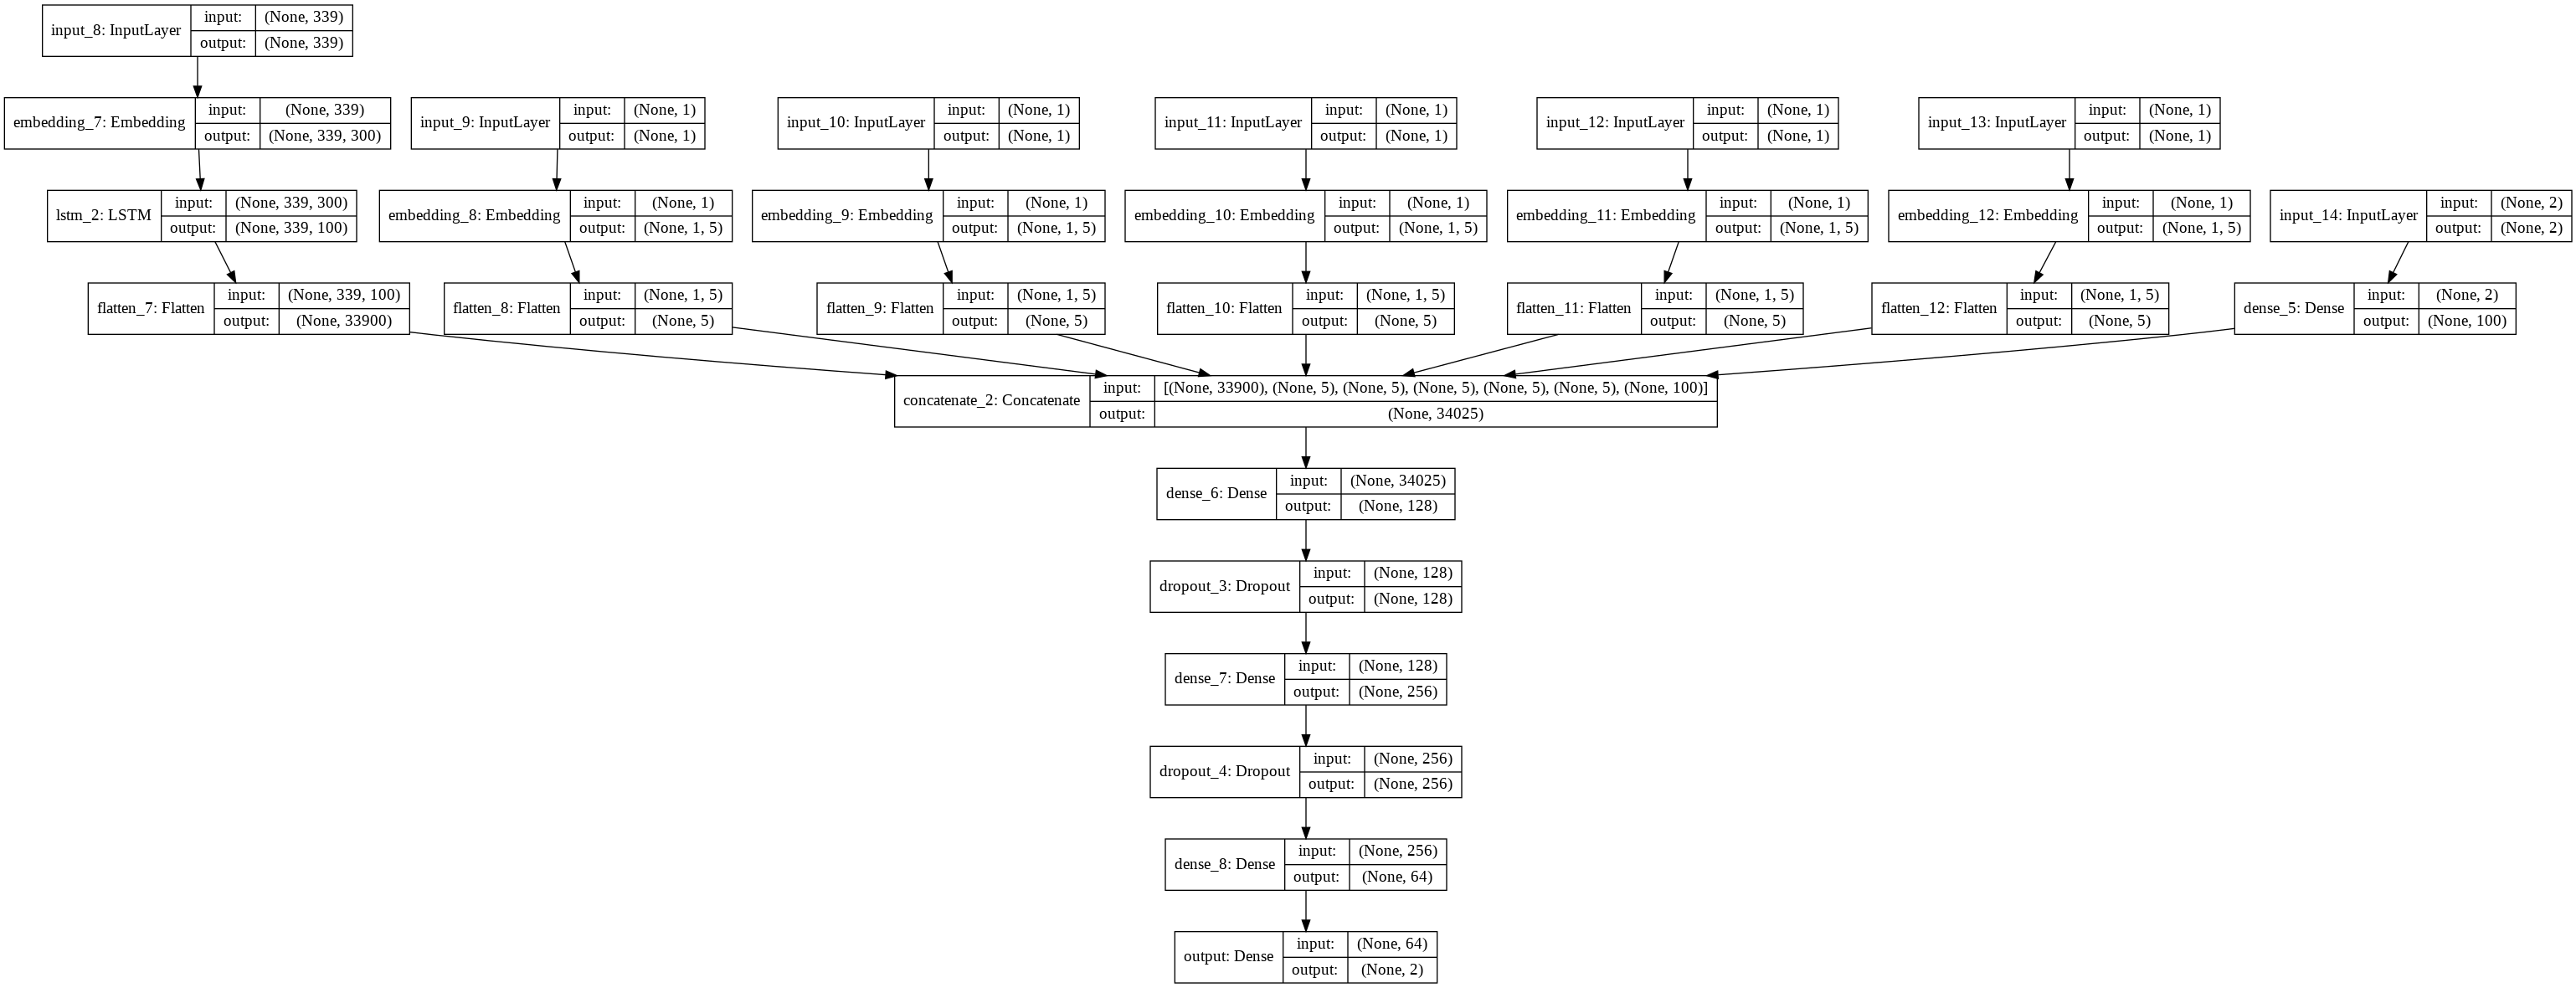

In [0]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model_1, to_file='model_1.png', show_shapes=True, show_layer_names=True)

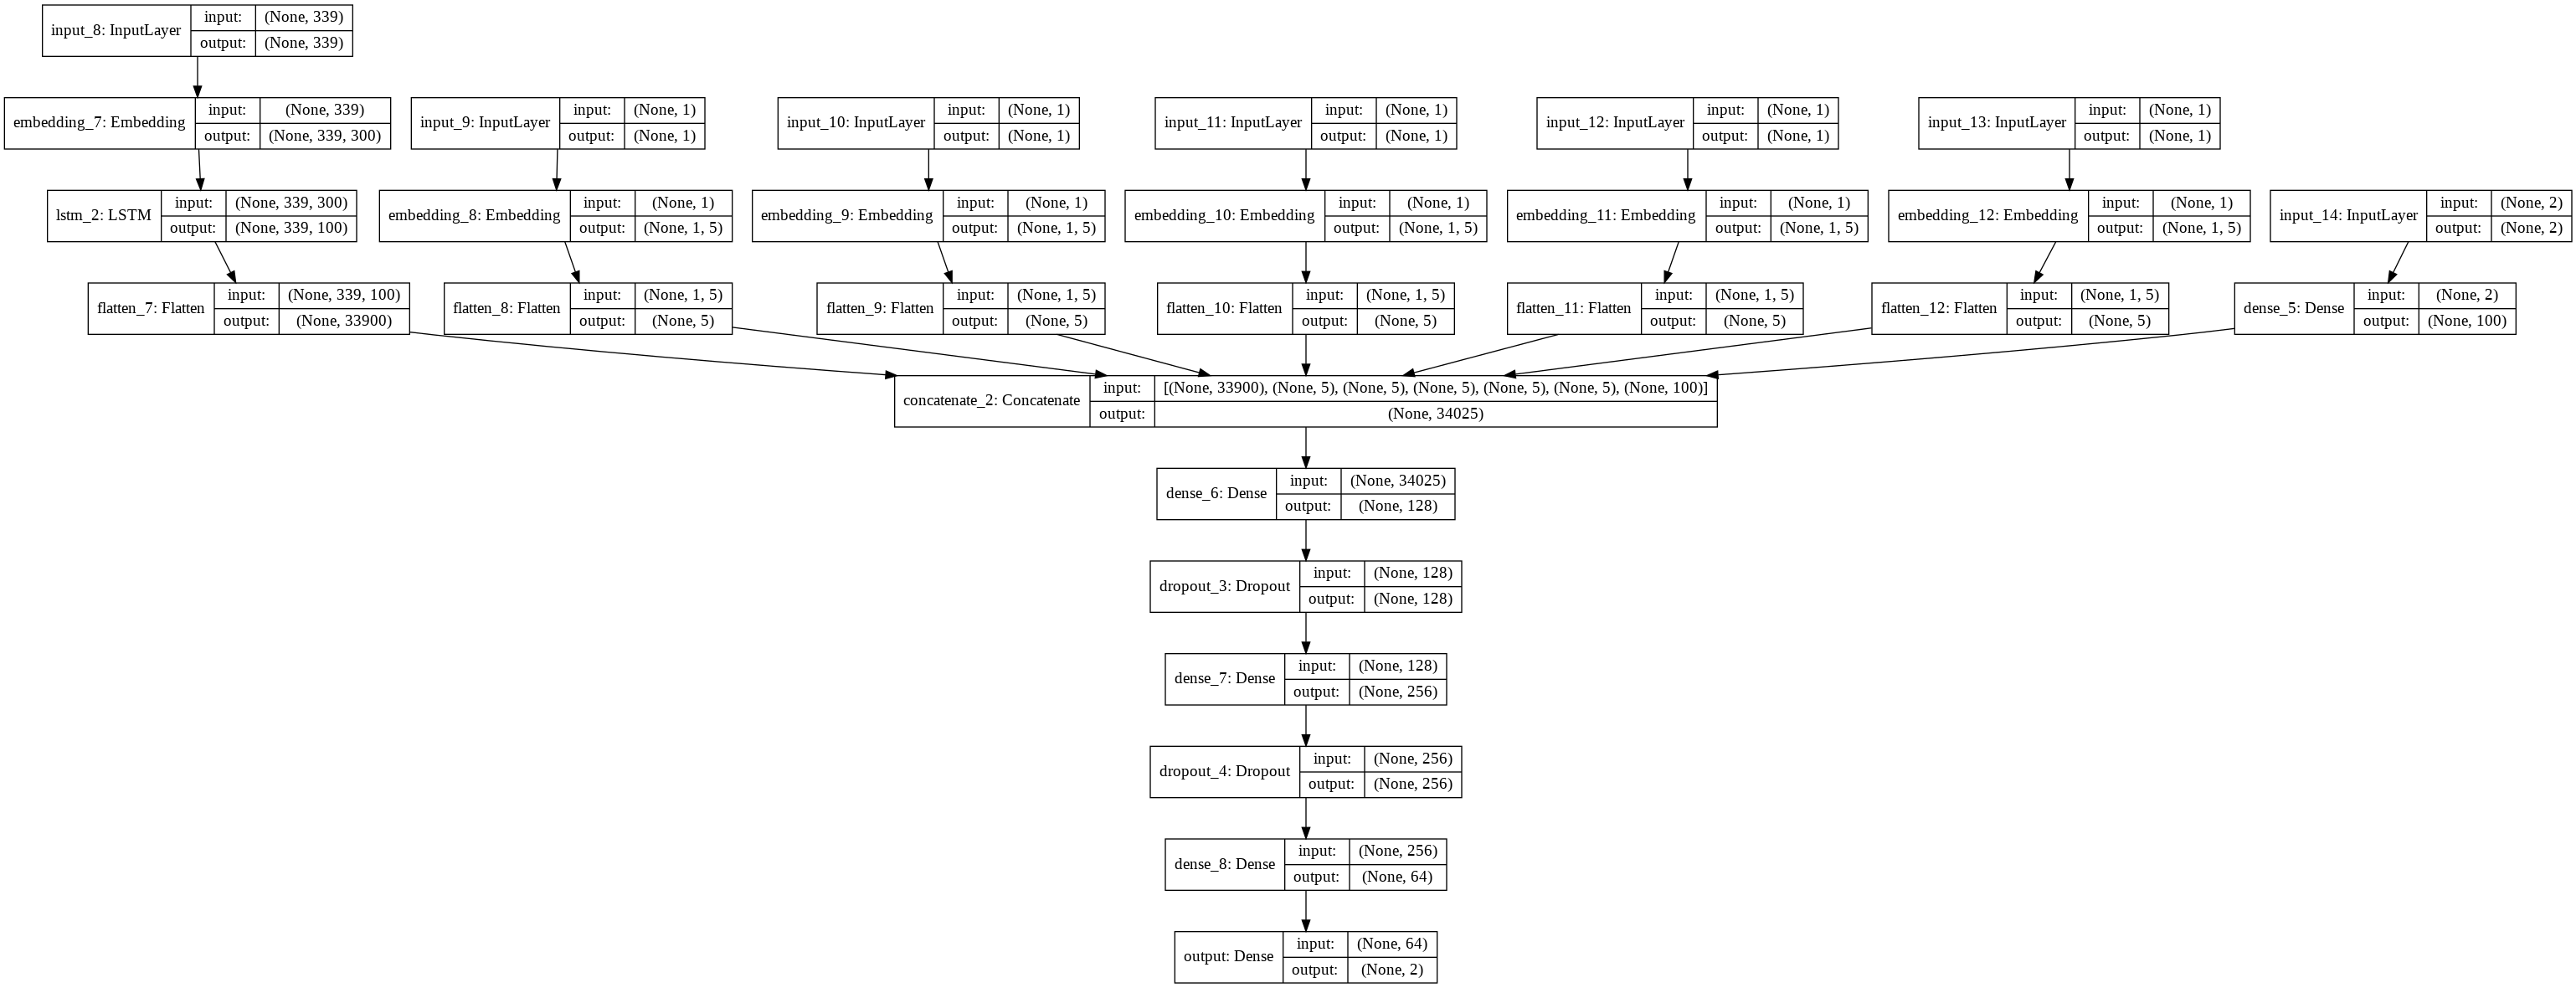

In [0]:
from IPython.display import Image
Image(retina=True, filename='model_1.png')

In [0]:
#Use to convert categorical data into numerical indexes
lb = LabelEncoder()
padded_pre_train = lb.fit_transform(x_train["teacher_prefix"])
padded_pre_test = lb.transform(x_test["teacher_prefix"])
padded_pre_cv = lb.transform(x_cv["teacher_prefix"])

In [0]:
padded_st_train = lb.fit_transform(x_train["school_state"])
padded_st_test = lb.transform(x_test["school_state"])
padded_st_cv = lb.transform(x_cv["school_state"])

In [0]:
padded_grade_train = lb.fit_transform(x_train["project_grade_category"])
padded_grade_test = lb.transform(x_test["project_grade_category"])
padded_grade_cv = lb.transform(x_cv["project_grade_category"])

In [0]:
#https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
le = LabelEncoder()
le.fit(x_train["clean_categories"])
x_test["clean_categories"] = x_test["clean_categories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
x_cv["clean_categories"] = x_cv["clean_categories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, '<unknown>')
padded_cat_train = le.transform(x_train["clean_categories"])
padded_cat_test= le.transform(x_test["clean_categories"])
padded_cat_cv = le.transform(x_cv["clean_categories"])

In [0]:
#https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
le = LabelEncoder()
le.fit(x_train["clean_subcategories"])
x_test["clean_subcategories"] = x_test["clean_subcategories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
x_cv["clean_subcategories"] = x_cv["clean_subcategories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, '<unknown>')
padded_sub_train = le.transform(x_train["clean_subcategories"])
padded_sub_test= le.transform(x_test["clean_subcategories"])
padded_sub_cv = le.transform(x_cv["clean_subcategories"])

In [0]:
padded_data_train = [padded_essay_train,padded_pre_train,padded_st_train,
              padded_grade_train,padded_cat_train,padded_sub_train,num_train]
padded_data_test = [padded_essay_test,padded_pre_test,padded_st_test,
              padded_grade_test,padded_cat_test,padded_sub_test,num_test]
padded_data_cv = [padded_essay_cv,padded_pre_cv,padded_st_cv,
              padded_grade_cv,padded_cat_cv,padded_sub_cv,num_cv]

In [0]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, 2) 
y_cv=np_utils.to_categorical(y_cv, 2) 
y_test = np_utils.to_categorical(y_test, 2)

In [0]:
#https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [0]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auc])

W0903 03:55:16.917448 140355349870464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0903 03:55:16.970332 140355349870464 deprecation.py:323] From <ipython-input-89-f9a5f6075828>:5: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, 

In [0]:
#https://keras.io/callbacks/
#https://www.tensorflow.org/tensorboard/r2/get_started

tensorboard_1 = TensorBoard(log_dir='direc',histogram_freq=1, batch_size=512, update_freq='epoch')
checkpoint_1 = ModelCheckpoint("model_1.h5",monitor="auc",mode="max",save_best_only = True,verbose=1)

callb1=[tensorboard_1,checkpoint_1]

In [0]:
trained_model = model_1.fit(padded_data_train,y_train,batch_size=512,epochs=20,validation_data=(padded_data_cv,y_cv),callbacks=callb1)

W0903 03:55:24.038502 140355349870464 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 69918 samples, validate on 17480 samples


W0903 03:55:26.272625 140355349870464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1120: The name tf.summary.histogram is deprecated. Please use tf.compat.v1.summary.histogram instead.

W0903 03:55:26.337683 140355349870464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1122: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0903 03:55:26.341767 140355349870464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1125: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/20
69918/69918 [==============================] - 110s 2ms/step - loss: 1.2176 - auc: 0.6359 - val_loss: 0.9385 - val_auc: 0.7009

Epoch 00001: auc improved from -inf to 0.63587, saving model to model_1.h5
Epoch 2/20
69918/69918 [==============================] - 108s 2ms/step - loss: 0.8124 - auc: 0.7039 - val_loss: 0.7439 - val_auc: 0.7292

Epoch 00002: auc improved from 0.63587 to 0.70394, saving model to model_1.h5
Epoch 3/20
69918/69918 [==============================] - 109s 2ms/step - loss: 0.7801 - auc: 0.7348 - val_loss: 0.9822 - val_auc: 0.7406

Epoch 00003: auc improved from 0.70394 to 0.73481, saving model to model_1.h5
Epoch 4/20
69918/69918 [==============================] - 109s 2ms/step - loss: 1.0792 - auc: 0.7377 - val_loss: 1.1166 - val_auc: 0.7382

Epoch 00004: auc improved from 0.73481 to 0.73772, saving model to model_1.h5
Epoch 5/20
69918/69918 [==============================] - 107s 2ms/step - loss: 1.0501 - auc: 0.7484 - val_loss: 1.0669 - val_auc: 0.68

21850/21850 [==============================] - 14s 620us/step
Test Loss: 0.7624210124757798
Test AUC: 0.7476403863075476


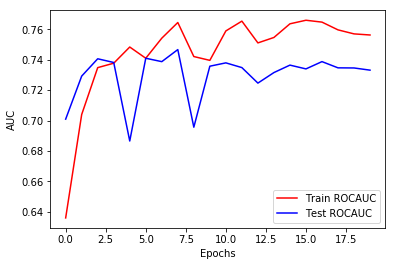

In [0]:
score = model_1.evaluate(padded_data_test, y_test, verbose=1,batch_size=512) 
print('Test Loss:', score[0]) 
print('Test AUC:', score[1])

plt.plot(trained_model.history['auc'], 'r')
plt.plot(trained_model.history['val_auc'], 'b')
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend({'Train ROCAUC': 'r', 'Test ROCAUC':'b'})

plt.show()

In [8]:
!pip install -q tf-nightly-2.0-preview
%load_ext tensorboard

     |████████████████████████████████| 89.7MB 302kB/s 
     |████████████████████████████████| 3.8MB 47.8MB/s 
     |████████████████████████████████| 460kB 71.1MB/s 


In [0]:
%tensorboard --logdir direc
!kill 1345

Reusing TensorBoard on port 6006 (pid 1345), started 0:05:20 ago. (Use '!kill 1345' to kill it.)

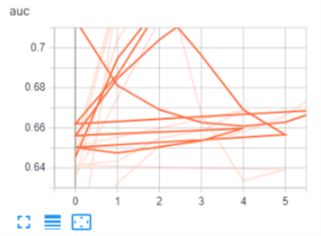

In [0]:
from IPython.display import Image
Image('auc1.png')

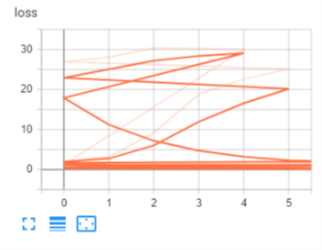

In [0]:
Image('loss1.png')

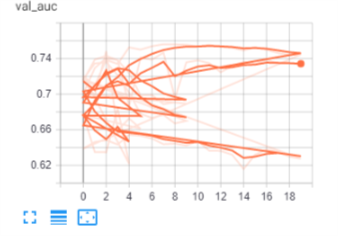

In [0]:
Image('val_auc1.png')

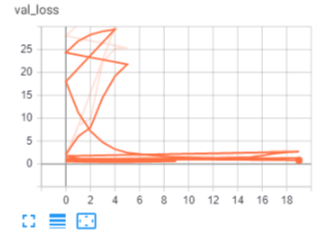

In [0]:
Image('val_loss1.png')

### Model-2

Use the same model as above but for 'input_seq_total_text_data' give only some words in the sentance not all the words. Filter the words as below. 

<pre>
1. Train the TF-IDF on the Train data feature 'essay' <br>
2. Get the idf value for each word we have in the train data. <br>
3. Remove the low idf value and high idf value words from our data. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very frequent words and very very rare words don't give much information. (you can plot a box plots and take only the idf scores within IQR range and corresponding words)<br>
4. Train the LSTM after removing the Low and High idf value words. (In model-1 Train on total data but in Model-2 train on data after removing some words based on IDF values)
</pre>

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf_essay = TfidfVectorizer(min_df=10)
text_tfidf_train = vectorizer_tfidf_essay.fit_transform(x_train['essay'])
text_tfidf_test = vectorizer_tfidf_essay.transform(x_test['essay'])
text_tfidf_cv = vectorizer_tfidf_essay.transform(x_cv['essay'])
print("Shape of matrix after tf-idf encoding ",text_tfidf_train.shape)
print("Shape of matrix after tf-idf encoding ",text_tfidf_test.shape)
print("Shape of matrix after tf-idf encoding ",text_tfidf_cv.shape)

Shape of matrix after tf-idf encoding  (69918, 13982)
Shape of matrix after tf-idf encoding  (21850, 13982)
Shape of matrix after tf-idf encoding  (17480, 13982)


In [0]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(vectorizer_tfidf_essay.get_feature_names(), list(vectorizer_tfidf_essay.idf_)))

In [9]:
import operator
sorted_x = sorted(dictionary.items(), key=operator.itemgetter(1))
print(sorted_x)

[('students', 1.007709961308162), ('nannan', 1.044901084612567), ('school', 1.1629590312752571), ('my', 1.245418876654536), ('learning', 1.361781609972533), ('classroom', 1.39334616000881), ('not', 1.4501866997877837), ('learn', 1.4624434978883367), ('the', 1.471363268220638), ('they', 1.5010148795350806), ('help', 1.5144889376894484), ('many', 1.5753498427417898), ('need', 1.6659875080142381), ('we', 1.7184506863824631), ('work', 1.7271429343426177), ('come', 1.7335556867762068), ('use', 1.779198166769584), ('able', 1.82846386251041), ('love', 1.8487434333934676), ('also', 1.862100067102082), ('day', 1.8713211127206115), ('this', 1.8746081115028779), ('class', 1.8893955561943097), ('our', 1.9243538730662675), ('make', 1.9353720701405792), ('year', 2.0081884994777512), ('new', 2.0117224883130307), ('these', 2.019977694668997), ('one', 2.02554585923641), ('would', 2.0338360206547623), ('student', 2.044103300307264), ('time', 2.0521397316718843), ('want', 2.071202104660193), ('skills', 2

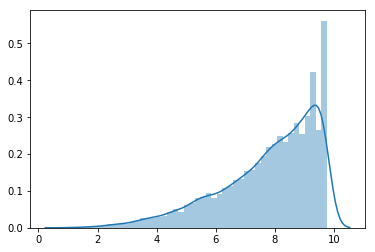

In [10]:
d=[]
for i in sorted_x:
    d.append(i[1])
np.array(d).astype(np.float)
sns.distplot(d, hist=True, kde=True)
             

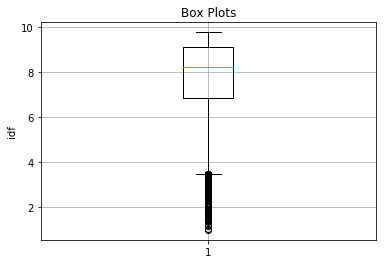

In [11]:
plt.boxplot(d)
plt.title('Box Plots')
plt.xlabel('')
plt.ylabel('idf')
plt.grid()
plt.show()

In [0]:
vocab=[]
for i in sorted_x:
    if (i[1]>2 and i[1]<11):
        vocab.append(i[0])

In [13]:
new_essay=[]
for sen in tqdm(x_train['essay'].values):
    sentence=list()
    words=sen.split()
    for word in words:
        if  word in vocab:
            sentence.append(word)
    new=' '.join(sentence)
    new_essay.append(new)

100%|██████████| 69918/69918 [13:13<00:00, 88.13it/s]


In [14]:
new_essay=np.array(new_essay)
corpus=[]
essay_len=[]
cnt=0
for sen in new_essay:
  cnt=0
  for word in sen.split():
    corpus.append(word)
    cnt=cnt+1
  essay_len.append(cnt)
max_len=max(essay_len)
print("Maximum Essay length =",max_len)
corpus=set(corpus)
vocab_size=len(corpus)
print("No of unique words ",vocab_size)

Maximum Essay length = 284
No of unique words  13957


In [0]:
# convert the sentences (strings) into integers
token = Tokenizer()
token.fit_on_texts(new_essay)
sequences_train = token.texts_to_sequences(x_train["essay"])
sequences_test = token.texts_to_sequences(x_test["essay"])
sequences_cv = token.texts_to_sequences(x_cv["essay"])

In [16]:
padded_essay_train = pad_sequences(sequences_train,maxlen=max_len)
print('Shape of padded_essay_train ', padded_essay_train.shape)

Shape of padded_essay_train  (69918, 284)


In [17]:
padded_essay_test = pad_sequences(sequences_test, maxlen=max_len)
print('Shape ofpadded_essay_test', padded_essay_test.shape)

Shape ofpadded_essay_test (21850, 284)


In [18]:
padded_essay_cv = pad_sequences(sequences_cv, maxlen=max_len)
print('Shape of padded_essay_cv', padded_essay_cv.shape)

Shape of padded_essay_cv (17480, 284)


In [0]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# loading glove_vectors file
import pickle
with open('glove_vectors.txt', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size+1, 300))
for word, i in token.word_index.items():
    embedding_vector = model.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [21]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
embedding_layer = Embedding(
  vocab_size+1,
  300,
  weights=[embedding_matrix],
  input_length=max_len,
  trainable=False
)
input_layer = Input(shape=(max_len,))
embedding =embedding_layer(input_layer)
x = LSTM(100, return_sequences=True)(embedding)
flatten = Flatten()(x)

W0904 04:09:42.316145 139643214432128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 04:09:42.366869 139643214432128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0904 04:09:42.375912 139643214432128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0904 04:09:42.391561 139643214432128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0904 04:09:42.392548 1396432144

In [22]:
no_of_unique_state  = x_train["school_state"].nunique()
print('Unique State:', no_of_unique_state)

Unique State: 51


In [0]:
input_state = Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_state)
flatten_1=Flatten()(embedding)


In [24]:
no_of_unique_grade  = x_train["project_grade_category"].nunique()
print('Unique Grades:', no_of_unique_grade)

Unique Grades: 4


In [0]:
input_grade = Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_grade)
flatten_2=Flatten()(embedding)


In [26]:
no_of_unique_prefix  = x_train["teacher_prefix"].nunique()
print('Unique Prefixes ', no_of_unique_prefix)

Unique Prefixes  5


In [0]:
input_pre = Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_pre)
flatten_3=Flatten()(embedding)


In [28]:
no_of_unique_cat  = x_train["clean_categories"].nunique()
print('Unique Categories ', no_of_unique_cat)

Unique Categories  50


In [0]:
input_cat= Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_cat)
flatten_4=Flatten()(embedding)

In [30]:
no_of_unique_sub  = x_train["clean_subcategories"].nunique()
print('Unique SubCategories ', no_of_unique_sub)

Unique SubCategories  386


In [0]:
input_sub = Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_sub)
flatten_5=Flatten()(embedding)


In [0]:
#we have two numerical fetures 
price_train=x_train['price'].values.reshape(-1, 1)
teach_train=x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

price_test=x_test['price'].values.reshape(-1, 1)
teach_test=x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

price_cv=x_cv['price'].values.reshape(-1, 1)
teach_cv=x_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

num_train=np.concatenate((price_train,teach_train),axis=1)

num_test=np.concatenate((price_test,teach_test),axis=1)

num_cv=np.concatenate((price_cv,teach_cv),axis=1)

In [0]:
st=StandardScaler()
num_train=st.fit_transform(num_train)
num_test=st.transform(num_test)
num_cv=st.transform(num_cv)

In [0]:
Input_num = Input(shape=(2,))
rem_input = Dense(100,activation="relu",kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.001))(Input_num)

In [35]:
print("Building Model-2")
x_concatenate = concatenate([flatten,flatten_1,flatten_2,flatten_3,flatten_4,flatten_5,rem_input])
x = Dense(128, activation='relu',kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x_concatenate)
x=Dropout(0.5)(x)
x = Dense(256, activation='relu',kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x=Dropout(0.5)(x)
x = Dense(64, activation='relu',kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
output = Dense(2, activation='softmax', name='output')(x)
model_2 = Model(inputs=[input_layer,input_state,input_grade,input_pre,input_cat,input_sub,Input_num],outputs=[output])

Building Model-2


W0904 04:09:53.668721 139643214432128 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [36]:
#Printing Model Summary
print(model_2.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 284)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 284, 300)     4187400     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
____________________________________________________________________________________________

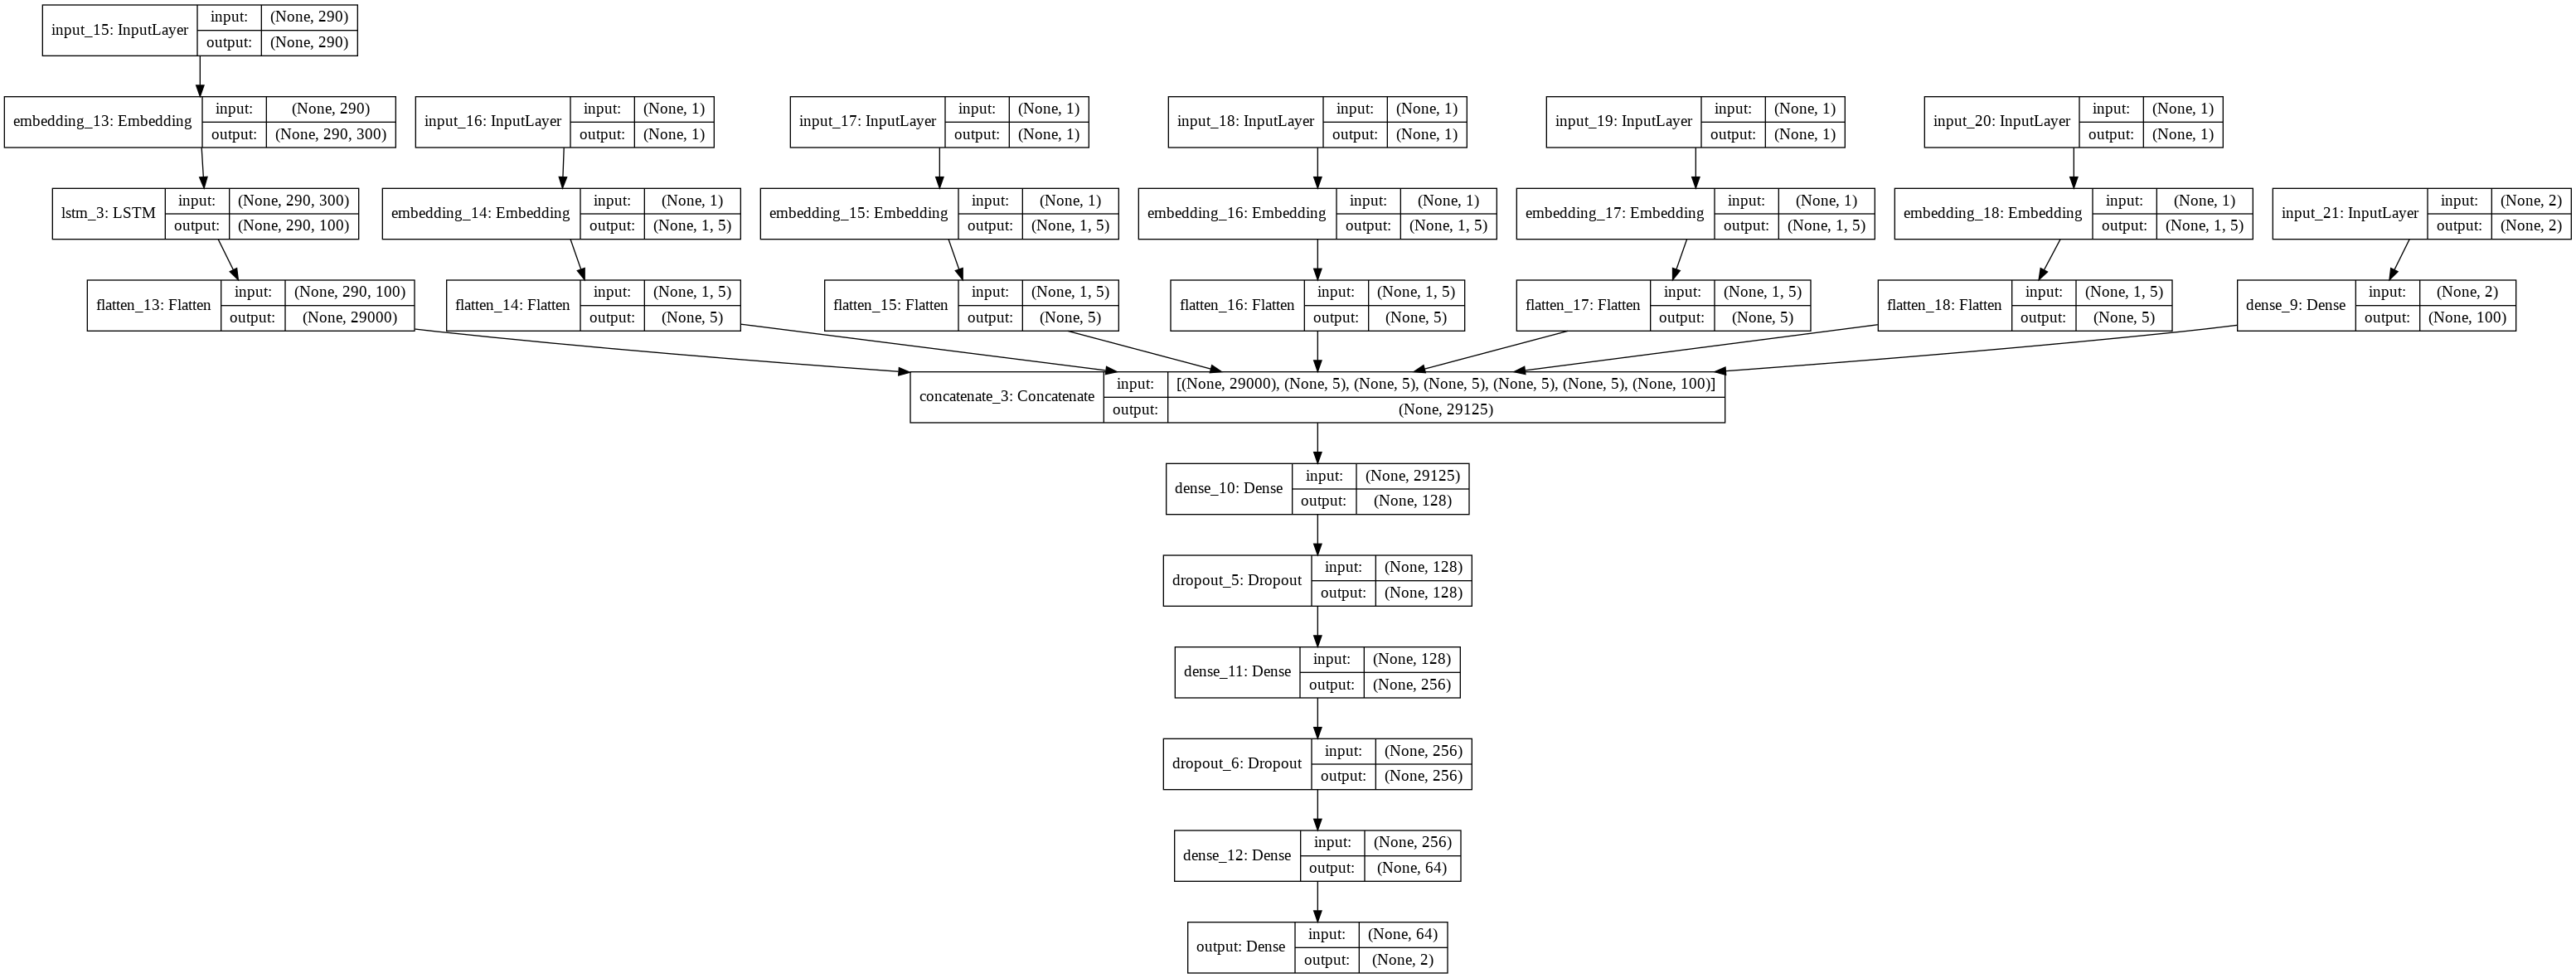

In [0]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model_2, to_file='model_2.png', show_shapes=True, show_layer_names=True)

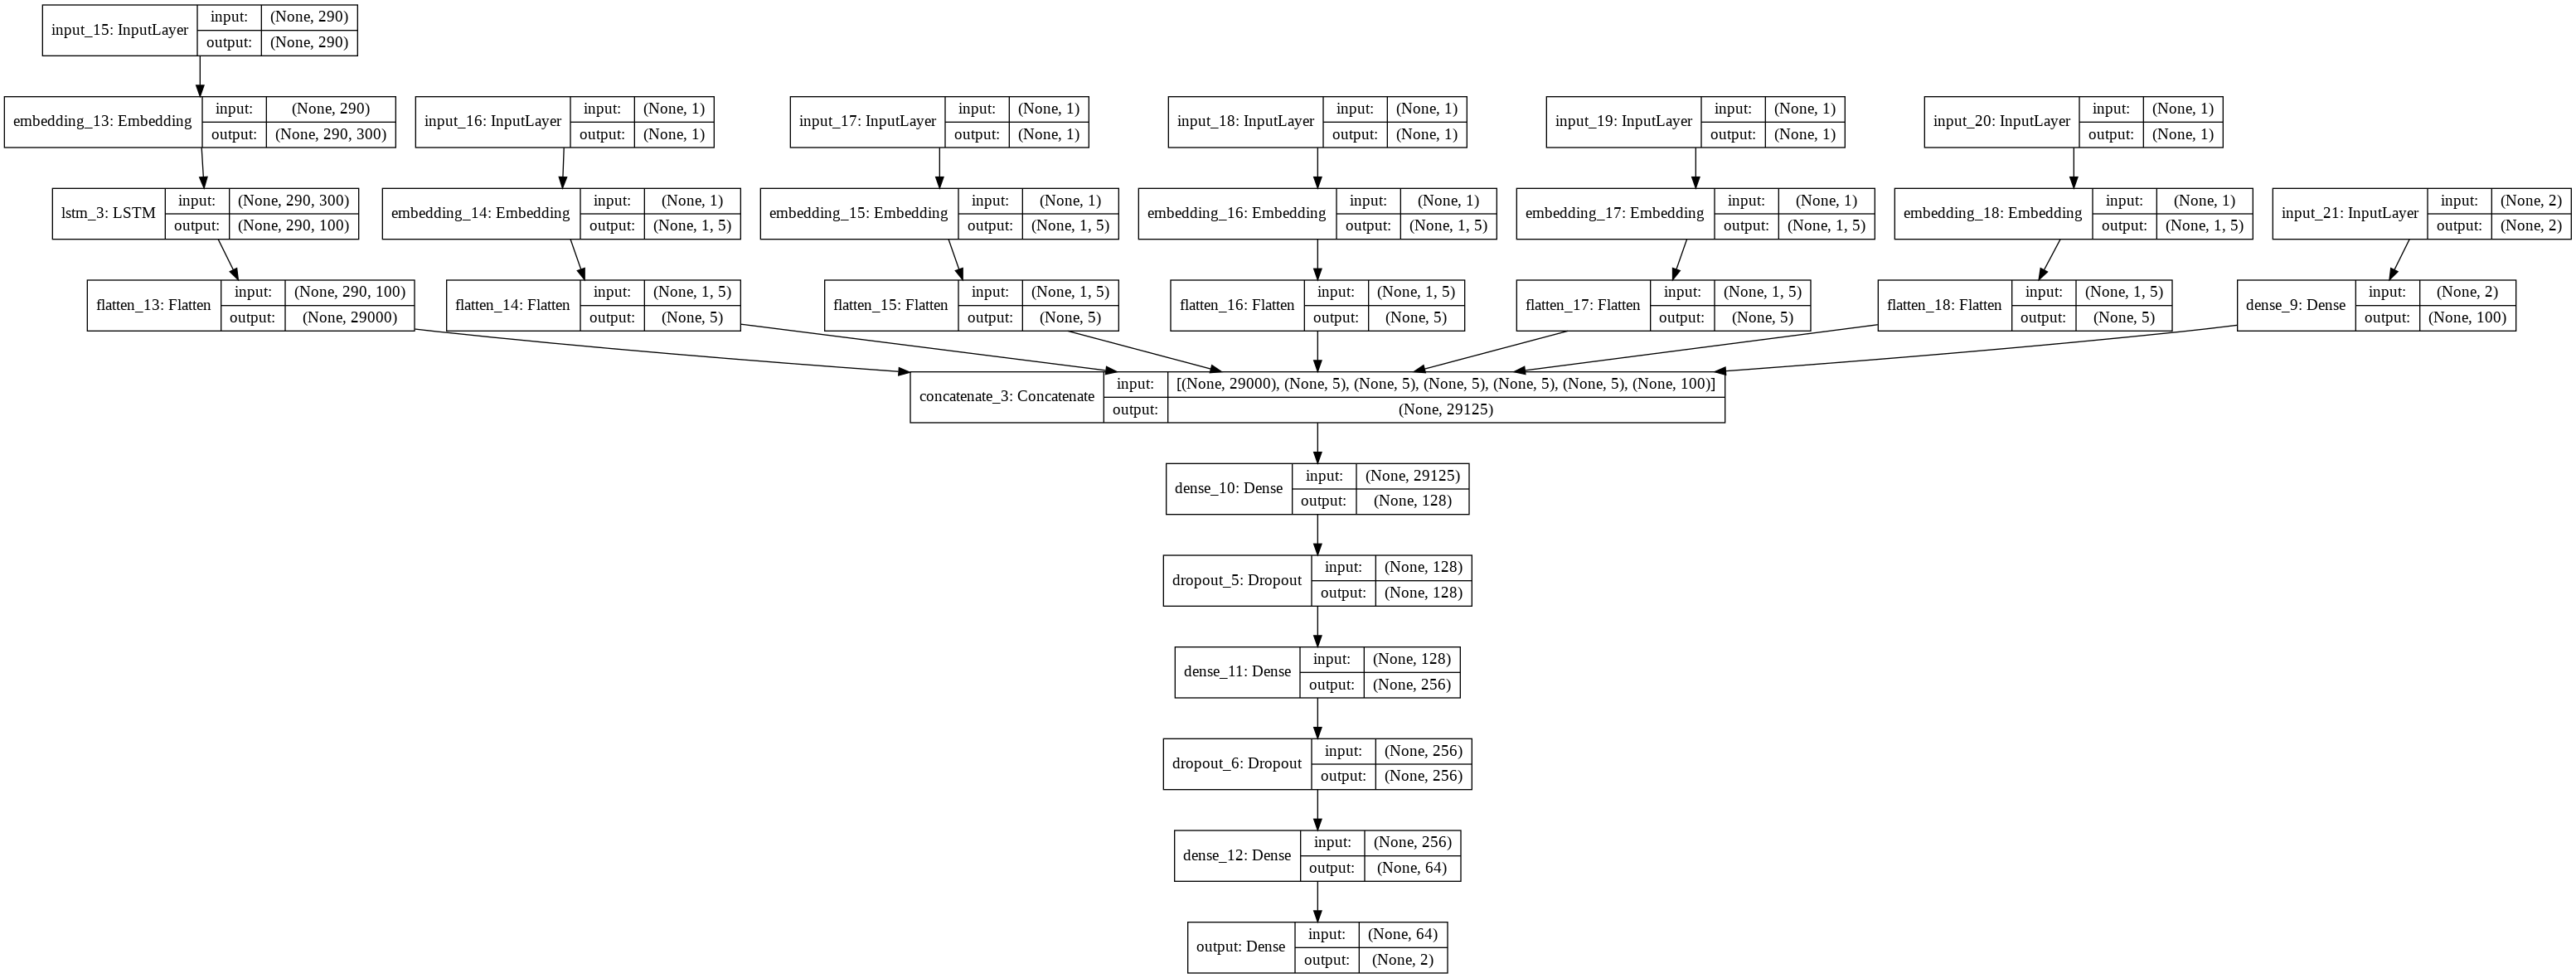

In [0]:
from IPython.display import Image
Image(retina=True, filename='model_2.png')

In [0]:
#Use to convert categorical data into numerical indexes
lb = LabelEncoder()
padded_pre_train = lb.fit_transform(x_train["teacher_prefix"])
padded_pre_test = lb.transform(x_test["teacher_prefix"])
padded_pre_cv = lb.transform(x_cv["teacher_prefix"])

In [0]:
padded_st_train = lb.fit_transform(x_train["school_state"])
padded_st_test = lb.transform(x_test["school_state"])
padded_st_cv = lb.transform(x_cv["school_state"])

In [0]:
padded_grade_train = lb.fit_transform(x_train["project_grade_category"])
padded_grade_test = lb.transform(x_test["project_grade_category"])
padded_grade_cv = lb.transform(x_cv["project_grade_category"])

In [0]:
#https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
le = LabelEncoder()
le.fit(x_train["clean_categories"])
x_test["clean_categories"] = x_test["clean_categories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
x_cv["clean_categories"] = x_cv["clean_categories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, '<unknown>')
padded_cat_train = le.transform(x_train["clean_categories"])
padded_cat_test= le.transform(x_test["clean_categories"])
padded_cat_cv = le.transform(x_cv["clean_categories"])

In [0]:
#https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
le = LabelEncoder()
le.fit(x_train["clean_subcategories"])
x_test["clean_subcategories"] = x_test["clean_subcategories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
x_cv["clean_subcategories"] = x_cv["clean_subcategories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, '<unknown>')
padded_sub_train = le.transform(x_train["clean_subcategories"])
padded_sub_test= le.transform(x_test["clean_subcategories"])
padded_sub_cv = le.transform(x_cv["clean_subcategories"])

In [0]:
padded_data_train = [padded_essay_train,padded_pre_train,padded_st_train,
              padded_grade_train,padded_cat_train,padded_sub_train,num_train]
padded_data_test = [padded_essay_test,padded_pre_test,padded_st_test,
              padded_grade_test,padded_cat_test,padded_sub_test,num_test]
padded_data_cv = [padded_essay_cv,padded_pre_cv,padded_st_cv,
              padded_grade_cv,padded_cat_cv,padded_sub_cv,num_cv]

In [0]:
#https://keras.io/callbacks/
#https://www.tensorflow.org/tensorboard/r2/get_started

earlystop_2 = EarlyStopping(monitor = 'val_loss', mode="min",min_delta = 0, patience = 2,verbose = 1,restore_best_weights = True)
tensorboard_2 = TensorBoard(log_dir='direc',histogram_freq=1, batch_size=512, update_freq='epoch')
checkpoint_2 = ModelCheckpoint("model_2.h5",monitor="auc",mode="max",save_best_only = True,verbose=1)

callb2=[tensorboard_2,checkpoint_2,earlystop_2]

In [46]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auc])

W0904 04:10:38.035421 139643214432128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0904 04:10:38.087903 139643214432128 deprecation.py:323] From <ipython-input-44-f9a5f6075828>:5: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, 

In [47]:
trained_model = model_2.fit(padded_data_train,y_train,batch_size=512,epochs=20,validation_data=(padded_data_cv,y_cv),callbacks=callb2)

W0904 04:10:42.263510 139643214432128 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 69918 samples, validate on 17480 samples


W0904 04:10:44.497558 139643214432128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1120: The name tf.summary.histogram is deprecated. Please use tf.compat.v1.summary.histogram instead.

W0904 04:10:44.562132 139643214432128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1122: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0904 04:10:44.566757 139643214432128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1125: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/20
69918/69918 [==============================] - 90s 1ms/step - loss: 1.9260 - auc: 0.6298 - val_loss: 2.0729 - val_auc: 0.7204

Epoch 00001: auc improved from -inf to 0.62980, saving model to model_2.h5
Epoch 2/20
69918/69918 [==============================] - 88s 1ms/step - loss: 1.9172 - auc: 0.7066 - val_loss: 1.8549 - val_auc: 0.7481

Epoch 00002: auc improved from 0.62980 to 0.70658, saving model to model_2.h5
Epoch 3/20
69918/69918 [==============================] - 88s 1ms/step - loss: 1.7701 - auc: 0.7312 - val_loss: 1.8242 - val_auc: 0.7432

Epoch 00003: auc improved from 0.70658 to 0.73118, saving model to model_2.h5
Epoch 4/20
69918/69918 [==============================] - 88s 1ms/step - loss: 1.7326 - auc: 0.7459 - val_loss: 1.7602 - val_auc: 0.7543

Epoch 00004: auc improved from 0.73118 to 0.74588, saving model to model_2.h5
Epoch 5/20
69918/69918 [==============================] - 88s 1ms/step - loss: 1.7430 - auc: 0.7586 - val_loss: 1.7881 - val_auc: 0.7583

E

21850/21850 [==============================] - 11s 493us/step
Test Loss: 1.7615136656881196
Test AUC: 0.7473506223044523


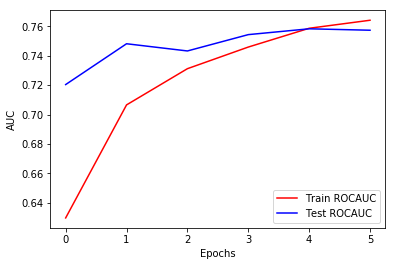

In [48]:
score = model_2.evaluate(padded_data_test, y_test, verbose=1,batch_size=512) 
print('Test Loss:', score[0]) 
print('Test AUC:', score[1])

plt.plot(trained_model.history['auc'], 'r')
plt.plot(trained_model.history['val_auc'], 'b')
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend({'Train ROCAUC': 'r', 'Test ROCAUC':'b'})

plt.show()

In [0]:
%tensorboard --logdir direc
!kill 895

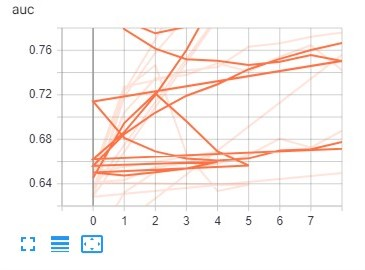

In [54]:
from IPython.display import Image
Image('auc2.jpg')

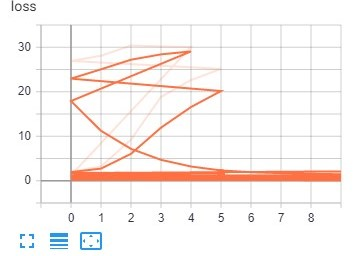

In [56]:
Image('loss.jpg')

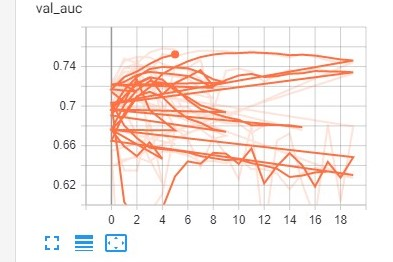

In [57]:
Image('val_auc2.jpg')

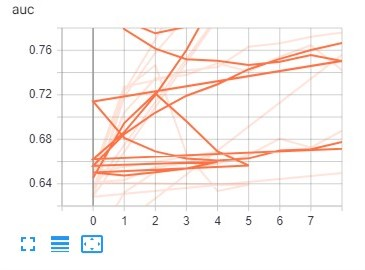

In [58]:
Image('//content/auc2.jpg')

### Model-3

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png


- __input_seq_total_text_data__: <br>
<pre>
    . Use text column('essay'), and use the Embedding layer to get word vectors. <br>
    . Use given predefined glove word vectors, don't train any word vectors. <br>
    . Use LSTM that is given above, get the LSTM output and Flatten that output. <br>
    . You are free to preprocess the input text as you needed. <br>
</pre>
- __Other_than_text_data__:<br>
<pre>
    . Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors <br>
    . Neumerical values and use <a href='https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions'>CNN1D</a> as shown in above figure. <br>
    . You are free to choose all CNN parameters like kernel sizes, stride.<br>
    
</pre>

In [9]:
corpus=[]
essay_len=[]
cnt=0
for sen in x_train['essay'].values:
  cnt=0
  for word in sen.split():
    corpus.append(word)
    cnt=cnt+1
  essay_len.append(cnt)
max_len=max(essay_len)
print("Maximum Essay length =",max_len)
corpus=set(corpus)
vocab_size=len(corpus)
print("No of unique words ",vocab_size)

Maximum Essay length = 333
No of unique words  47309


In [0]:
# convert the sentences (strings) into integers
token = Tokenizer()
token.fit_on_texts(x_train["essay"])
sequences_train = token.texts_to_sequences(x_train["essay"])
sequences_test = token.texts_to_sequences(x_test["essay"])
sequences_cv = token.texts_to_sequences(x_cv["essay"])

In [11]:
padded_essay_train = pad_sequences(sequences_train,maxlen=max_len)
print('Shape of padded_essay_train ', padded_essay_train.shape)

Shape of padded_essay_train  (69918, 333)


In [12]:
padded_essay_test = pad_sequences(sequences_test, maxlen=max_len)
print('Shape ofpadded_essay_test', padded_essay_test.shape)

Shape ofpadded_essay_test (21850, 333)


In [13]:
padded_essay_cv = pad_sequences(sequences_cv, maxlen=max_len)
print('Shape of padded_essay_cv', padded_essay_cv.shape)

Shape of padded_essay_cv (17480, 333)


In [0]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# loading glove_vectors file
import pickle
with open('glove_vectors.txt', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size+1, 300))
for word, i in token.word_index.items():
    embedding_vector = model.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [16]:
embedding_matrix

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.15243  , -0.16945  , -0.022748 , ...,  0.61801  ,  0.41281  ,
         0.0010077],
       [-0.043504 , -0.18484  , -0.14613  , ...,  0.1008   ,  0.1068   ,
         0.089065 ],
       ...,
       [-0.34994  , -0.23886  , -0.40774  , ..., -0.2823   ,  0.1155   ,
        -0.14283  ],
       [-0.080622 , -0.26125  , -0.36019  , ..., -0.22261  ,  0.14714  ,
        -0.19806  ],
       [ 0.43349  , -0.30552  ,  0.51933  , ...,  0.22712  ,  0.056115 ,
         0.12647  ]])

In [0]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [18]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
embedding_layer = Embedding(
  vocab_size+1,
  300,
  weights=[embedding_matrix],
  input_length=max_len,
  trainable=False
)
input_layer = Input(shape=(max_len,))
embedding =embedding_layer(input_layer)
x = LSTM(100, return_sequences=True)(embedding)
flatten = Flatten()(x)

W0904 04:51:35.127702 140060075661184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 04:51:35.162733 140060075661184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0904 04:51:35.175544 140060075661184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0904 04:51:35.185245 140060075661184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0904 04:51:35.185946 1400600756

In [19]:
# we use count vectorizer to convert the values into one 
from sklearn.feature_extraction.text import CountVectorizer
cat_vocab=set(x_train['clean_categories'].values)
vectorizer = CountVectorizer(vocabulary=list(cat_vocab), lowercase=False, binary=True)
categories_one_hot_train = vectorizer.fit_transform(x_train['clean_categories'].values)
print("Shape of matrix after one hot encoding ",categories_one_hot_train.shape)

Shape of matrix after one hot encoding  (69918, 51)


In [20]:
categories_one_hot_test = vectorizer.transform(x_test['clean_categories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encoding ",categories_one_hot_test.shape)

['history_civics music_arts', 'math_science health_sports', 'literacy_language warmth care_hunger', 'history_civics math_science', 'literacy_language history_civics', 'music_arts specialneeds', 'music_arts', 'history_civics warmth care_hunger', 'music_arts warmth care_hunger', 'math_science specialneeds', 'literacy_language appliedlearning', 'math_science', 'literacy_language health_sports', 'health_sports warmth care_hunger', 'specialneeds health_sports', 'history_civics specialneeds', 'literacy_language music_arts', 'history_civics appliedlearning', 'literacy_language math_science', 'math_science music_arts', 'math_science appliedlearning', 'health_sports music_arts', 'math_science history_civics', 'appliedlearning literacy_language', 'specialneeds warmth care_hunger', 'health_sports', 'health_sports history_civics', 'appliedlearning history_civics', 'literacy_language specialneeds', 'health_sports literacy_language', 'math_science literacy_language', 'appliedlearning math_science', 

In [21]:
categories_one_hot_cv = vectorizer.transform(x_cv['clean_categories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encoding ",categories_one_hot_cv.shape)

['history_civics music_arts', 'math_science health_sports', 'literacy_language warmth care_hunger', 'history_civics math_science', 'literacy_language history_civics', 'music_arts specialneeds', 'music_arts', 'history_civics warmth care_hunger', 'music_arts warmth care_hunger', 'math_science specialneeds', 'literacy_language appliedlearning', 'math_science', 'literacy_language health_sports', 'health_sports warmth care_hunger', 'specialneeds health_sports', 'history_civics specialneeds', 'literacy_language music_arts', 'history_civics appliedlearning', 'literacy_language math_science', 'math_science music_arts', 'math_science appliedlearning', 'health_sports music_arts', 'math_science history_civics', 'appliedlearning literacy_language', 'specialneeds warmth care_hunger', 'health_sports', 'health_sports history_civics', 'appliedlearning history_civics', 'literacy_language specialneeds', 'health_sports literacy_language', 'math_science literacy_language', 'appliedlearning math_science', 

In [22]:
# we use count vectorizer to convert the values into one 
subcat_vocab=set(x_train['clean_subcategories'].values)
vectorizer = CountVectorizer(vocabulary=list(subcat_vocab), lowercase=False, binary=True)
subcategories_one_hot_train = vectorizer.fit_transform(x_train['clean_subcategories'].values)
print("Shape of matrix after one hot encoding ",subcategories_one_hot_train.shape)

Shape of matrix after one hot encoding  (69918, 385)


In [23]:
subcategories_one_hot_test = vectorizer.transform(x_test['clean_subcategories'].values)
print("Shape of matrix after one hot encoding ",subcategories_one_hot_test.shape)

Shape of matrix after one hot encoding  (21850, 385)


In [24]:
subcategories_one_hot_cv = vectorizer.transform(x_cv['clean_subcategories'].values)
print("Shape of matrix after one hot encoding ",subcategories_one_hot_cv.shape)

Shape of matrix after one hot encoding  (17480, 385)


In [25]:
# we use count vectorizer to convert the values into one 
state_vocab=set(x_train['school_state'].values)
vectorizer = CountVectorizer(vocabulary=list(state_vocab), lowercase=False, binary=True)
state_one_hot_train=vectorizer.fit_transform(x_train['school_state'].values)
state_one_hot_test=vectorizer.transform(x_test['school_state'].values)
state_one_hot_cv=vectorizer.transform(x_cv['school_state'].values)
print(vectorizer.get_feature_names())

print("Shape of matrix after one hot encoding ",state_one_hot_train.shape)
print("Shape of matrix after one hot encoding ",state_one_hot_test.shape)
print("Shape of matrix after one hot encoding ",state_one_hot_cv.shape)

['az', 'ut', 'or', 'ar', 'ne', 'nv', 'id', 'sd', 'me', 'ga', 'ri', 'la', 'pa', 'ny', 'ia', 'nj', 'tn', 'va', 'mo', 'wa', 'nc', 'wy', 'md', 'nm', 'nh', 'ma', 'ct', 'oh', 'ak', 'hi', 'in', 'mt', 'sc', 'tx', 'co', 'nd', 'ms', 'ok', 'ky', 'wi', 'mi', 'ks', 'ca', 'il', 'de', 'dc', 'mn', 'al', 'wv', 'vt', 'fl']
Shape of matrix after one hot encoding  (69918, 51)
Shape of matrix after one hot encoding  (21850, 51)
Shape of matrix after one hot encoding  (17480, 51)


In [26]:
grade_vocab=set(x_train['project_grade_category'].values)
vectorizer = CountVectorizer(vocabulary=list(grade_vocab), lowercase=False, binary=True)
grade_one_hot_train=vectorizer.fit_transform(x_train['project_grade_category'].values)
grade_one_hot_test=vectorizer.transform(x_test['project_grade_category'].values)
grade_one_hot_cv=vectorizer.transform(x_cv['project_grade_category'].values)
print(vectorizer.get_feature_names())

print("Shape of matrix after one hot encoding ",grade_one_hot_train.shape)
print("Shape of matrix after one hot encoding ",grade_one_hot_test.shape)
print("Shape of matrix after one hot encoding ",grade_one_hot_cv.shape)

['grades_9_12', 'grades_6_8', 'grades_prek_2', 'grades_3_5']
Shape of matrix after one hot encoding  (69918, 4)
Shape of matrix after one hot encoding  (21850, 4)
Shape of matrix after one hot encoding  (17480, 4)


In [27]:
prefix_vocab=set(x_train['teacher_prefix'].values)
vectorizer = CountVectorizer(vocabulary=list(prefix_vocab), lowercase=False, binary=True)
teacher_one_hot_train=vectorizer.fit_transform(x_train['teacher_prefix'].values)
teacher_one_hot_test=vectorizer.transform(x_test['teacher_prefix'].values)
teacher_one_hot_cv=vectorizer.transform(x_cv['teacher_prefix'].values)
print(vectorizer.get_feature_names())

print("Shape of matrix after one hot encoding ",teacher_one_hot_train.shape)
print("Shape of matrix after one hot encoding ",teacher_one_hot_test.shape)
print("Shape of matrix after one hot encoding ",teacher_one_hot_cv.shape)

['teacher', 'dr', 'mrs', 'mr', 'ms']
Shape of matrix after one hot encoding  (69918, 5)
Shape of matrix after one hot encoding  (21850, 5)
Shape of matrix after one hot encoding  (17480, 5)


In [0]:
from scipy.sparse import hstack

categorical_train =hstack((categories_one_hot_train,subcategories_one_hot_train,state_one_hot_train,grade_one_hot_train,teacher_one_hot_train))
categorical_test = hstack((categories_one_hot_test,subcategories_one_hot_test,state_one_hot_test,grade_one_hot_test,teacher_one_hot_test))
categorical_cv = hstack((categories_one_hot_cv,subcategories_one_hot_cv,state_one_hot_cv,grade_one_hot_cv,teacher_one_hot_cv))

In [29]:
print(categorical_train.shape)
print(categorical_test.shape)
print(categorical_cv.shape)

(69918, 496)
(21850, 496)
(17480, 496)


In [0]:
#we have two numerical fetures 
price_train=x_train['price'].values.reshape(-1, 1)
teach_train=x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

price_test=x_test['price'].values.reshape(-1, 1)
teach_test=x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

price_cv=x_cv['price'].values.reshape(-1, 1)
teach_cv=x_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

num_train=np.concatenate((price_train,teach_train),axis=1)

num_test=np.concatenate((price_test,teach_test),axis=1)

num_cv=np.concatenate((price_cv,teach_cv),axis=1)

In [0]:
st=StandardScaler()
num_train=st.fit_transform(num_train)
num_test=st.transform(num_test)
num_cv=st.transform(num_cv)

In [0]:
other_train = hstack((categorical_train,num_train)).todense()
other_test = hstack((categorical_test,num_test)).todense()
other_cv = hstack((categorical_cv,num_cv)).todense()

In [0]:
from numpy import newaxis
other_train=other_train[:,:,newaxis]
other_test=other_test[:,:,newaxis]
other_cv=other_cv[:,:,newaxis]

In [0]:
input_cat=Input(shape=(other_train.shape[1],1))
conv1=Conv1D(64,kernel_size=(3),activation='relu',kernel_initializer="he_normal")(input_cat)
conv2=Conv1D(64,kernel_size=(3),activation='relu',kernel_initializer="he_normal")(conv1)
flatten1 = Flatten()(conv2)

In [35]:
concat=concatenate([flatten,flatten1])
d1=Dense(128,activation='relu')(concat)
d2=Dropout(0.5)(d1)
x = Dense(64, activation='relu',kernel_initializer="he_normal")(d2)
x=Dropout(0.7)(x)
d3 = Dense(32, activation='relu',kernel_initializer="he_normal")(x)
output = Dense(2, activation='softmax', name='output')(d3)
model_3 = Model(inputs=[input_layer,input_cat],outputs=[output])


W0904 04:51:41.024635 140060075661184 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0904 04:51:41.048795 140060075661184 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [36]:
print(model_3.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 333)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 498, 1)       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 333, 300)     14193000    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 496, 64)      256         input_2[0][0]                    
____________________________________________________________________________________________

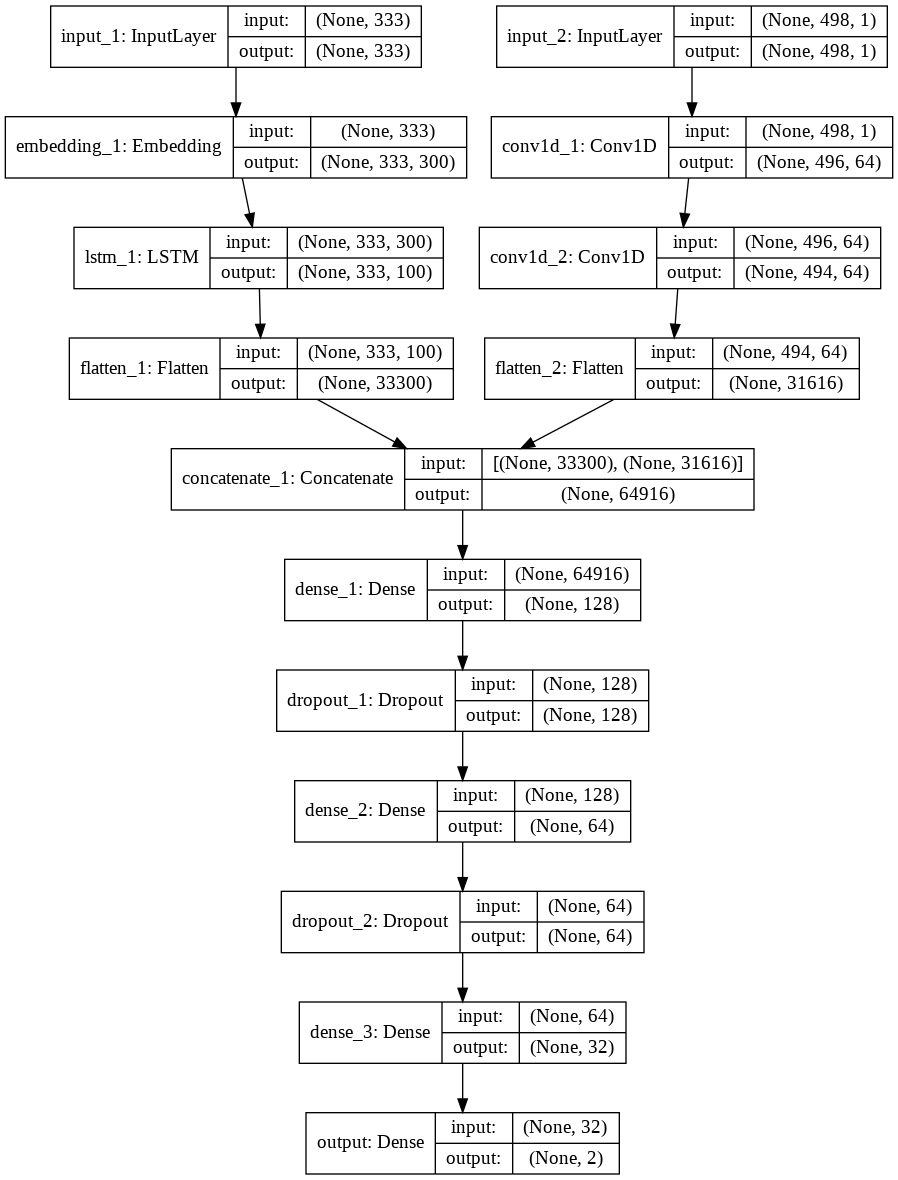

In [37]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model_3, to_file='model_3.png', show_shapes=True, show_layer_names=True)

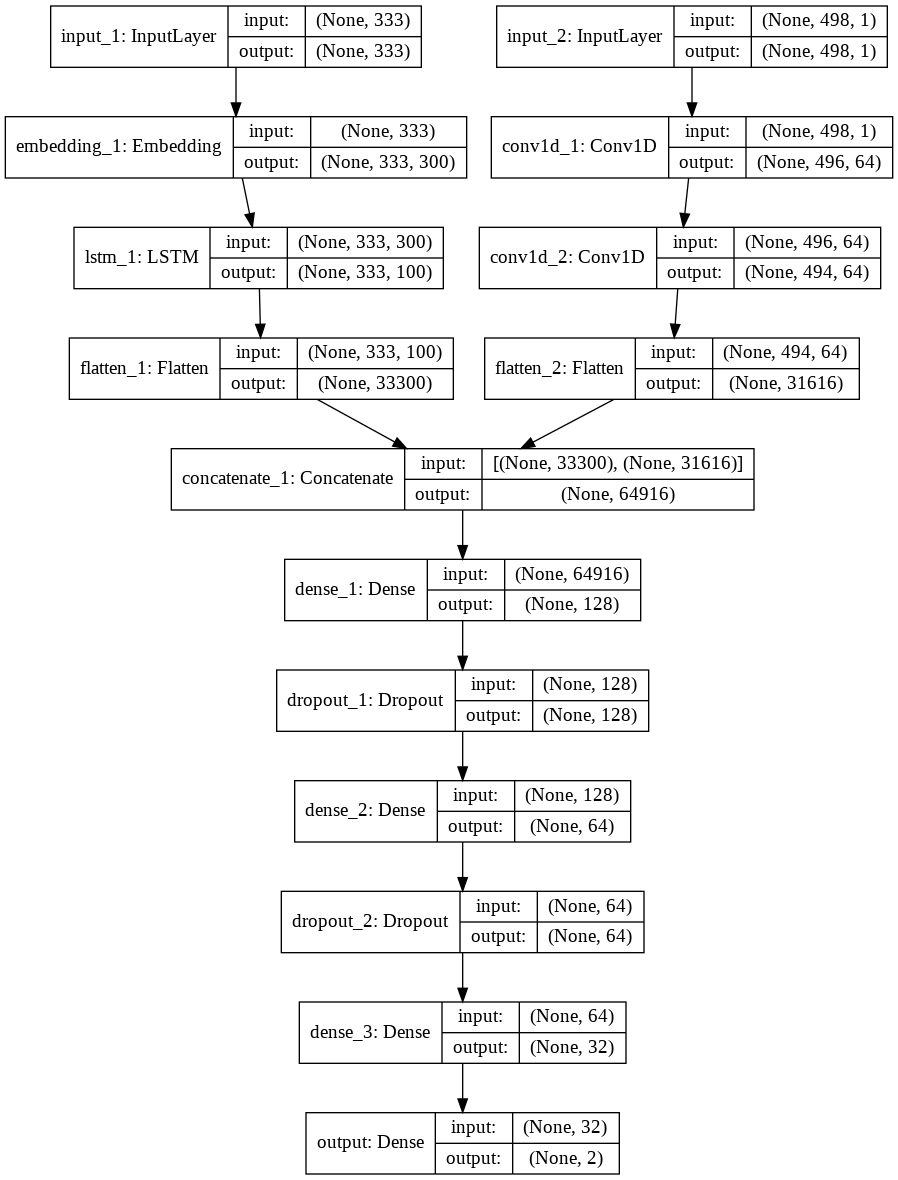

In [38]:
from IPython.display import Image
Image(retina=True, filename='model_3.png')

In [0]:
final_data_train=[padded_essay_train,other_train]
final_data_test=[padded_essay_test,other_test]
final_data_cv=[padded_essay_cv,other_cv]

In [0]:
#https://keras.io/callbacks/
#https://www.tensorflow.org/tensorboard/r2/get_started

earlystop_3 = EarlyStopping(monitor = 'val_loss', mode="min",min_delta = 0, patience = 2,verbose = 1,restore_best_weights = True)
tensorboard_3 = TensorBoard(log_dir='direc',histogram_freq=1, batch_size=512, update_freq='epoch')
checkpoint_3 = ModelCheckpoint("model_3.h5",monitor="auc",mode="max",save_best_only = True,verbose=1)

callb3=[tensorboard_3,checkpoint_3,earlystop_3]

In [41]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auc])

W0904 04:52:28.788568 140060075661184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0904 04:52:28.827931 140060075661184 deprecation.py:323] From <ipython-input-7-f9a5f6075828>:5: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, a

In [42]:
trained_model = model_3.fit(final_data_train,y_train,batch_size=512,epochs=10,validation_data=(final_data_cv,y_cv),callbacks=callb3)

W0904 04:52:33.154150 140060075661184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 69918 samples, validate on 17480 samples


W0904 04:52:35.035263 140060075661184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1120: The name tf.summary.histogram is deprecated. Please use tf.compat.v1.summary.histogram instead.

W0904 04:52:35.067782 140060075661184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1122: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0904 04:52:35.070349 140060075661184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1125: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/10
69918/69918 [==============================] - 85s 1ms/step - loss: 0.4699 - auc: 0.6060 - val_loss: 0.4483 - val_auc: 0.7132

Epoch 00001: auc improved from -inf to 0.60595, saving model to model_3.h5
Epoch 2/10
69918/69918 [==============================] - 81s 1ms/step - loss: 0.3960 - auc: 0.7106 - val_loss: 0.4175 - val_auc: 0.7347

Epoch 00002: auc improved from 0.60595 to 0.71060, saving model to model_3.h5
Epoch 3/10
69918/69918 [==============================] - 81s 1ms/step - loss: 0.3785 - auc: 0.7450 - val_loss: 0.3953 - val_auc: 0.7441

Epoch 00003: auc improved from 0.71060 to 0.74495, saving model to model_3.h5
Epoch 4/10
69918/69918 [==============================] - 81s 1ms/step - loss: 0.3655 - auc: 0.7703 - val_loss: 0.3887 - val_auc: 0.7451

Epoch 00004: auc improved from 0.74495 to 0.77028, saving model to model_3.h5
Epoch 5/10
69918/69918 [==============================] - 81s 1ms/step - loss: 0.3462 - auc: 0.8020 - val_loss: 0.3777 - val_auc: 0.7471

E

21850/21850 [==============================] - 10s 448us/step
Test Loss: 0.38119350945376695
Test AUC: 0.7385086694509703


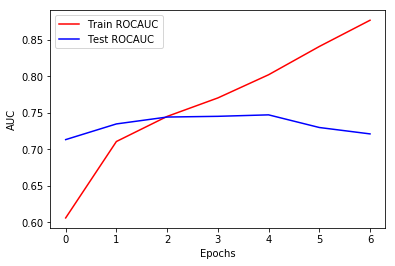

In [43]:
score = model_3.evaluate(final_data_test, y_test, verbose=1,batch_size=512) 
print('Test Loss:', score[0]) 
print('Test AUC:', score[1])

plt.plot(trained_model.history['auc'], 'r')
plt.plot(trained_model.history['val_auc'], 'b')
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend({'Train ROCAUC': 'r', 'Test ROCAUC':'b'})

plt.show()

In [44]:
%tensorboard --logdir direc

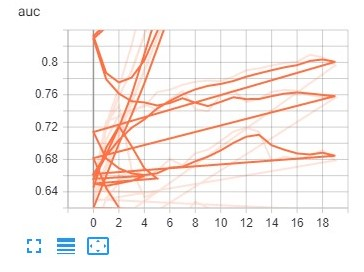

In [45]:
from IPython.display import Image
Image('auc3.jpg')

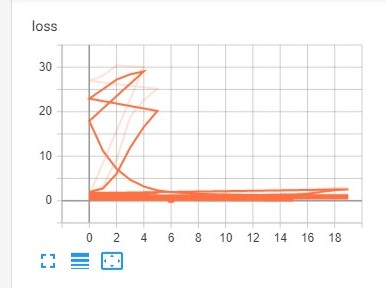

In [46]:
Image('loss3.jpg')

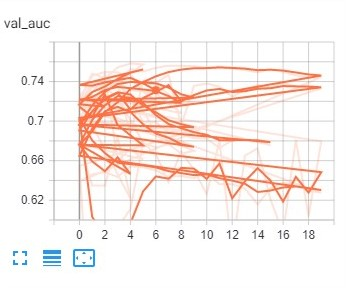

In [50]:
Image('val_auc3.jpg')

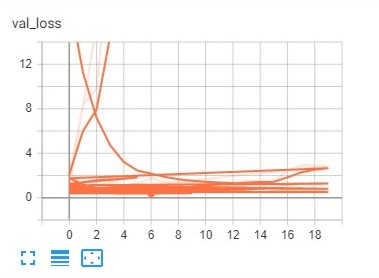

In [49]:
Image('val_loss3.jpg')

In [52]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Train AUC", "Test AUC"]

x.add_row(["Model 1", 0.756,0.733])
x.add_row(["Model 2", 0.758,0.747])
x.add_row(["Model 3", 0.876,0.738])

print(x)

+---------+-----------+----------+
|  Model  | Train AUC | Test AUC |
+---------+-----------+----------+
| Model 1 |   0.756   |  0.733   |
| Model 2 |   0.758   |  0.747   |
| Model 3 |   0.876   |  0.738   |
+---------+-----------+----------+
